In [75]:
import shap

import copy

import math

import pickle

import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import tensorflow.keras.backend as K
from tensorflow import keras 
import tensorflow as tf

import seaborn as sns; sns.set_theme()

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('seaborn-ticks')

import scipy.stats as st

import statsmodels as statsmodels
import statsmodels.stats.multitest as multitest
import statsmodels.formula.api as smf

## Variable Definitions

#### Input Data
__x_train_path__ - `String` - Path and file name of input values from the training dataset. Should be a .txt file saved from a numpy array using `numpy.savetxt()`

__x_test_path__ - `String` - Path and file name of input values from the training dataset. Should be a .txt file saved from a numpy array using `numpy.savetxt()`


#### Model
__kerasmodel__ - `Boolean` - Set to `True` if the model is a keras model able to be loaded with tf.keras.models.load_model(). Otherwise, set to False.
If `False`, set mload to your models predict class, i.e. `model.predict`

__model_path__ - `String` - Path to keras model.

__mload__ - `Class` - If `kerasmodel == False`, shap will use the predict class provided here directly. e.g. `model.predict` 

__input_dict__ - `Dictionary` - Dictionary linking understandable inputs to encoded inputs used in the model.
Ensure they are provided in the same order that the model was originally trained with.

__placeholder_index__ - `Integer` - Index of the placeholder input within input_dict dictionary if it were to be converted to a list. Used to exclude placeholders from
dependence analysis. Set to `-1` if you would like to include them in the analysis.


#### SHAP Values
__shap_values_pickle_path__ - `String` - Path and file name of where to save and load shap values from a pickle.

__output_index__ - `Integer` - If using a multi-output model, only one output can be analyzed by SHAP at a time. Set to the index of the
output you would like analyzed. If it is a single output model, set to `0`.


#### Output
__output_prefix__ - `String` - Sets the common prefix for all output data and figures. Can include path as well. 

__savefig__ - `Boolean` - `True` to save figures, `False` to not.

__filetype__ - `String` - File format to save figures in. matplotlib pyplot formats are accepted.

__showfig__ - `Boolean` - `True` to show figures in notebook, `False` to not.

#### Force Plots
__peptide_index__ - `Integer` - Index of the peptide within testing data to display using a force plot.

#### Dependence Plots
__compareto__ - `String` - Used only for dependence plots. Can be set to `'static'`, `'preceding'`, or `'following'`. If `'static'`, looks at
all positions compared to a single position defined by compared. If `'preceding'`, looks at the position preceding the current position.
If `'following'`, looks at the position following the current postion.

__compared__ - `Integer` - Used only for dependence plots if `compareto == 'static'`. Defines the position to compare each position to.

In [87]:
##########################################################################################

# Input Data
multioutput = False

#x_train_path = '20201230_all5_xtrain.txt'
#x_test_path = '20201230_all5_xtest.txt'
#y_train_path = '20201230_all5_ytrain.txt'

#x_train_path = '20210524_A1101_xtrain.txt'
#x_test_path = '20210524_A1101_xtest.txt'
#y_train_path = '20210524_A1101_ytrain.txt'

x_train_path = '20210429_CRT_CCS_xtrain.txt'
x_test_path = '20210429_CRT_CCS_xtest.txt'
y_train_path = '20210429_CRT_CCS_ytrain.txt'





#Training Data analysis

top = True

# Model
kerasmodel = True

#model_path = '20201230_MHC_all5.model'
#model_path = '20210608_A1101_final.model'
model_path = '20210603_CCS_200epoch.model'


mload = ''

input_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'END': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12,
 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}

placeholder_index = 4


# SHAP Values
#shap_values_pickle_path = 'shapvaluesallMamu.pkl'
#shap_values_pickle_path = "shapvaluesA1101.pkl"
shap_values_pickle_path = "shapvaluesCCS.pkl"

output_index = 0

# Output
#output_prefix = 'Mamu_final'
#output_prefix = 'A1101_final'
output_prefix = 'ccs_final'

savefig = True
filetype = ".svg"
showfig = True

#Force Plots
peptide_index = 0

#Heatmaps
useweight = False
standardize = False

#Dependence Plots
#set to 'static', 'preceding', 'following'
compareto = 'static'
compared = 2


###########################################################################################
#load train and test data

x_train = np.loadtxt(x_train_path)
x_test = np.loadtxt(x_test_path)
y_train = np.loadtxt(y_train_path)

#create dictionary to decode inputs
rev_input_dict = {}

i = 0
while i < len(input_dict):
    rev_input_dict[list(input_dict.values())[i]]=list(input_dict.keys())[i]
    i+=1

## Amino Acid Frequency Heatmap
Creates a heatmap of the occurance of each input at each position standardized to the highest count

Also calculates weight to modify other heatmaps.

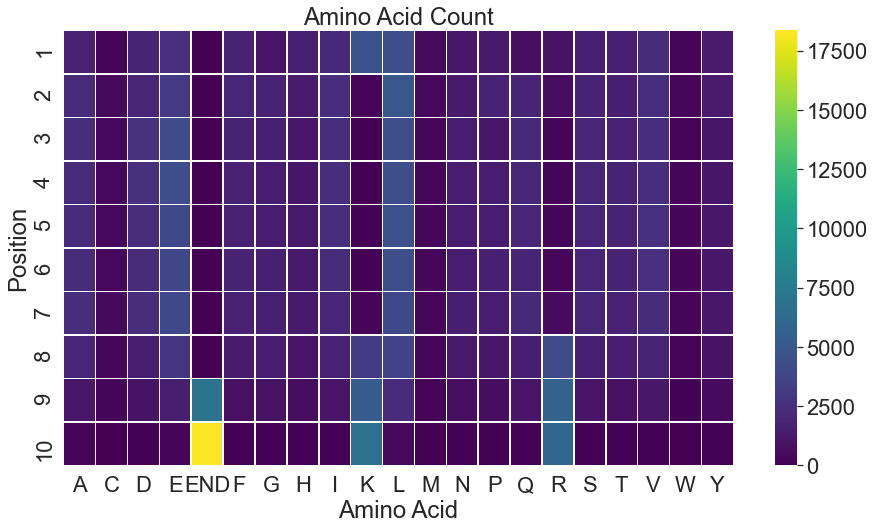

<Figure size 1080x576 with 0 Axes>

In [193]:
# Plot heatmap of peptide occurance 
if multioutput == True:
    df = pd.DataFrame(list(zip(x_train,  y_train[:,output_index])),
                   columns =['x_train', 'y_train'])
else:
    df = pd.DataFrame(list(zip(x_train,  y_train)),
                   columns =['x_train', 'y_train'])    

#HEATMAP 
heatmap = []
i = 0
while i<len(x_train[0]):
    heatmap.append([])
    j = 0
    while j < len(input_dict):
        heatmap[i].append(0)
        j+=1
    i+=1

i = 0
while i < len(np.asarray(df['x_train'])):
    j=0
    while j < len(np.asarray(df['x_train'])[i]):
        heatmap[j][int(np.asarray(df['x_train'])[i][j])]+=1
        
        j+=1
    i+=1 

weight = np.array(heatmap)/len(x_train)    
    
    
heatmap = np.array(heatmap)#*weight
if standardize == True:
    heatmap = heatmap/heatmap.max()
x_axis_labels = list(input_dict.keys()) # labels for x-axis
y_axis_labels = []
i = 1
for value in x_train[0]:
    y_axis_labels.append(str(i))
    i+=1

sns.set(font_scale=2)

# figure size in inches
rcParams['figure.figsize'] = 15,8

ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                 #vmax = 0.5,
                 linewidths=.5, cmap="viridis")


ax.set(xlabel='Amino Acid', ylabel='Position', title='Amino Acid Count')

if savefig == True:
    ax.figure.savefig(output_prefix + '-peptidecount_heatmap' + filetype)
if showfig == True:
    plt.show()
plt.clf()

## Linear Regression to get top inputs
Sorts training data by y values and calculates linear regression between rank and y-values. Creates new dataframe with 
values from the training data that are either above the regression and mean when `top == True`, or below the regression and mean.
when `top == False`

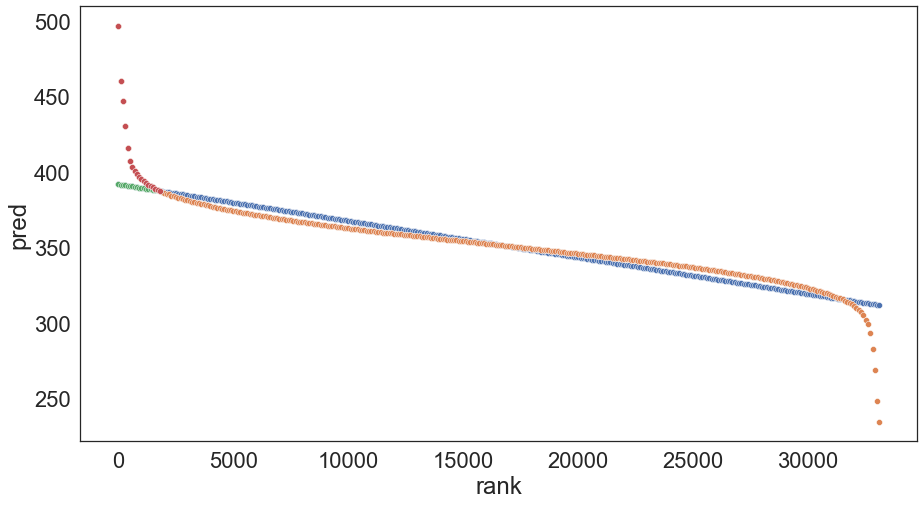

<Figure size 1080x576 with 0 Axes>

In [194]:
dfsort = df.sort_values(by=['y_train'], ascending = False)

count = [*range(1, len(y_train)+1, 1)]
dfsort['rank'] = count





# Initialise and fit linear regression model using `statsmodels`
model = smf.ols('y_train ~ rank', data=dfsort)
model = model.fit()
m, b = model.params

predict = model.predict()

dfsort['pred'] = predict
if top == True:
    dfpicks = dfsort.loc[dfsort['y_train'] > np.mean(dfsort['y_train']).tolist()]
    dfpicks = dfpicks.loc[dfpicks['pred'] <= dfpicks['y_train']]
else:
    dfpicks = dfsort.loc[dfsort['y_train'] < np.mean(dfsort['y_train']).tolist()]
    dfpicks = dfpicks.loc[dfpicks['pred'] >= dfpicks['y_train']]    

sns.set_style("white") 
x = dfsort['rank']
x = x[0:len(x):100]
y = dfsort['pred']
y = y[0:len(y):100]
y2 = dfsort['y_train']
y2 = y2[0:len(y2):100]
sns.scatterplot(x=x, y=y)
sns.scatterplot(x=x, y=y2)
#plt.yscale('log')
x = dfpicks['rank']
x = x[0:len(x):100]
y = dfpicks['pred']
y = y[0:len(y):100]
y2 = dfpicks['y_train']
y2 = y2[0:len(y2):100]
sns.scatterplot(x=x, y=y)
sns.scatterplot(x=x, y=y2)
dfpicks = dfpicks.sort_values('y_train' , ascending = False)

if savefig == True:
    plt.savefig(output_prefix + '-topinputregression' + filetype)
if showfig == True:
    plt.show()
plt.clf()

In [218]:
shap_values[0]

array([[ 0.01463663, -0.03300876,  0.08637533, ..., -0.00597471,
        -0.00832984, -0.01700543],
       [ 0.02096979, -0.0322774 ,  0.09083931, ..., -0.00538203,
        -0.01318526, -0.01410949],
       [ 0.02213142, -0.03358816,  0.11843805, ..., -0.00494177,
        -0.01494438,  0.03290627],
       ...,
       [-0.08904282,  0.15698245, -0.10219908, ...,  0.04704958,
         0.0236686 , -0.00530989],
       [-0.08679515,  0.15270191, -0.0880363 , ...,  0.02523238,
        -0.01724532,  0.00468885],
       [-0.08475813,  0.15075439, -0.08204573, ...,  0.02186496,
        -0.0158259 , -0.00363117]])

In [28]:
len(predictions[:,0])

6170

In [25]:
len(dfsort['predictions'])

5

In [30]:
predictions[0:8]

[0.08332749,
 0.080401614,
 0.16006438,
 0.27314404,
 0.2882723,
 0.3021773,
 0.2708664,
 0.27127874]

In [53]:
dfsort['predictions'][0:8]

5752    0.174611
3265    0.202920
5750    0.207966
5753    0.213089
5751    0.220016
3510    0.220833
5754    0.233149
3266    0.241564
Name: predictions, dtype: float64

In [49]:
dfsort['shap_values'][0]

array([[ 0.01463663, -0.03300876,  0.08637533, ..., -0.00597471,
        -0.00832984, -0.01700543],
       [ 0.02096979, -0.0322774 ,  0.09083931, ..., -0.00538203,
        -0.01318526, -0.01410949],
       [ 0.02213142, -0.03358816,  0.11843805, ..., -0.00494177,
        -0.01494438,  0.03290627],
       ...,
       [-0.08904282,  0.15698245, -0.10219908, ...,  0.04704958,
         0.0236686 , -0.00530989],
       [-0.08679515,  0.15270191, -0.0880363 , ...,  0.02523238,
        -0.01724532,  0.00468885],
       [-0.08475813,  0.15075439, -0.08204573, ...,  0.02186496,
        -0.0158259 , -0.00363117]])

[11.  7. 13.  0. 14. 17.  7. 14. 19.  2.]


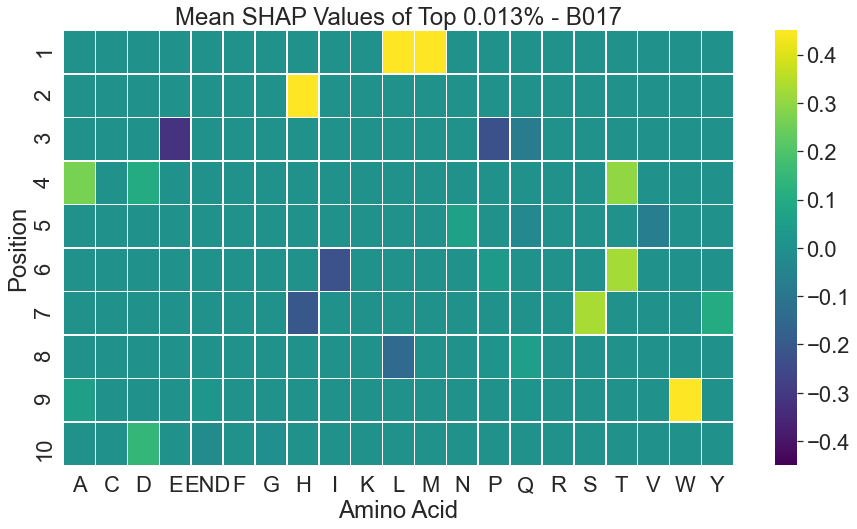

<Figure size 1080x576 with 0 Axes>

In [74]:
x_train = np.loadtxt(x_train_path)
x_test = np.loadtxt(x_test_path)
y_train = np.loadtxt(y_train_path)

output_index = 4

with open(shap_values_pickle_path,"rb") as f:
    shap_values = pickle.load(f)

mload = tf.keras.models.load_model(model_path)

predictions = mload.predict(x_test)
predictions = list(predictions[:,output_index])
df = pd.DataFrame(list(zip(x_test, shap_values[output_index], predictions)),
                   columns =['x_test','shap_values','predictions'])
dfsort = df.sort_values(by=['predictions'], ascending = False)

shap_values = [list(dfsort['shap_values'])[0:8]]
x_test = list(dfsort['x_test'])[0:8]
print(x_test[0])
#Create Mean Heatmaps for CCS


y_axis_labels = []   
x = 0
    
    
char_index = list(input_dict.keys())



aa = []
ph = []
for value in char_index:
    ph.append([0.0])

i = 0
while i < len(shap_values[0][0]):
    aa.append(copy.deepcopy(ph))
    y_axis_labels.append(str(i+1))
    i+=1


#create 3D array to keep track of amino acid position shap values
#Change shap values index for each allele 0 = A001 1 = A002 2 = A008 3 = B008 4 = B017
i = 0

while i < len(x_test):
    j=0

    while j < len(x_test[i]):
        aa[j][char_index.index(rev_input_dict[x_test[i][j]])].append(shap_values[0][i][j])
       

        j+=1
    i+=1 

heatmap = []
i = 0
while i < len(aa):
    j=0
    heatmap.append([])
    while j < len(aa[i]):
        if len(aa[i][j]) > 1:


            #remove extra zeros
            if len(aa[i][j]) > 1:
                aa[i][j] = aa[i][j][1:]
            #mean
            heatmap[i].append((sum(aa[i][j])/float(len(aa[i][j]))))

        else:
            heatmap[i].append(0)

            #print(char_index[j] + str(i+1) + ": ")
            #print ("0")
        j+=1
    i+=1

if useweight == True:
    heatmap = np.array(heatmap)/weight
else:
    heatmap = np.array(heatmap)#*weight
if standardize == True:
    heatmap = heatmap/heatmap.max()

plt.figure()
x_axis_labels = char_index # labels for x-axis

sns.set(font_scale=2)

# figure size in inches
rcParams['figure.figsize'] = 15,8

ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, 
                 vmax = 0.45,
                 vmin = -0.45,
                 yticklabels=y_axis_labels,linewidths=.5,  cmap="viridis")


ax.set(xlabel='Amino Acid', ylabel='Position', title='Mean SHAP Values of Top 0.013% - B017')
if savefig == True:
    ax.figure.savefig('Top8_heatmap_B017'+filetype)

if showfig == True:
    plt.show()
plt.clf()
x+=1

In [10]:
predictions[0]

array([0.08332749, 1.348374  , 0.2555588 , 0.3276428 , 0.069878  ],
      dtype=float32)

## Top/Bottom Peptide Amino Acid Frequency Heatmap
Uses values determined from linear regression above to plot the frequencies of each value in the top inputs when `top == True`
or bottom inputs when `top == False`

In [123]:
top = True

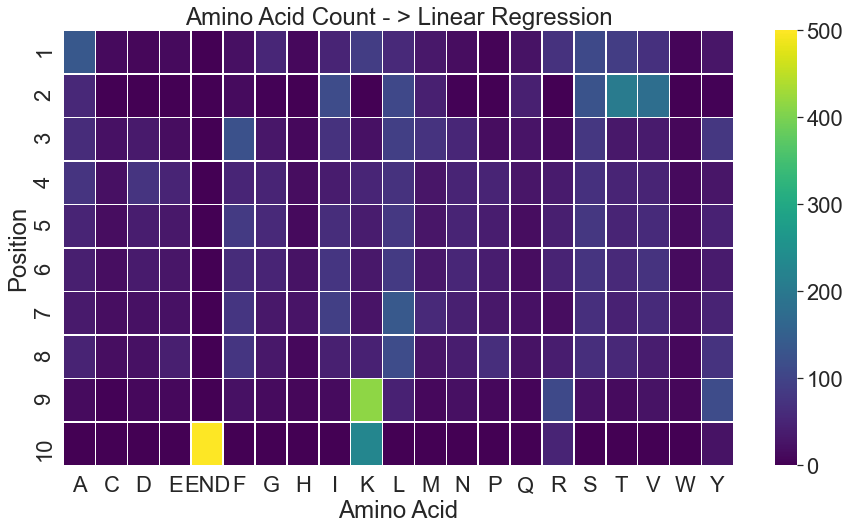

<Figure size 1080x576 with 0 Axes>

In [164]:
# Plot heatmap of peptide occurance 
if multioutput == True:
    df = pd.DataFrame(list(zip(x_train,  y_train[:,output_index])),
                   columns =['x_train', 'y_train'])
else:
    df = pd.DataFrame(list(zip(x_train,  y_train)),
                   columns =['x_train', 'y_train']) 




dfsort = df.sort_values(by=['y_train'], ascending = False)
#HEATMAP 
heatmap = []
i = 0
while i<len(x_train[0]):
    heatmap.append([])
    j = 0
    while j < len(input_dict):
        heatmap[i].append(0)
        j+=1
    i+=1

i = 0
while i < len(np.asarray(dfsort['x_train'][0:len(dfpicks)])):
    j=0
    while j < len(np.asarray(dfsort['x_train'][0:len(dfpicks)])[i]):
        heatmap[j][int(np.asarray(dfsort['x_train'][0:len(dfpicks)])[i][j])]+=1
        
        j+=1
    i+=1 


    
    
    
if useweight == True:
    heatmap = np.array(heatmap)/weight
else:
    heatmap = np.array(heatmap)#*weight
if standardize == True:
    heatmap = heatmap/heatmap.max()
x_axis_labels = list(input_dict.keys()) # labels for x-axis
y_axis_labels = []
i = 1
for value in x_train[0]:
    y_axis_labels.append(str(i))
    i+=1

sns.set(font_scale=2)

# figure size in inches
rcParams['figure.figsize'] = 15,8

ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, yticklabels=y_axis_labels,
                 vmax = 500,
                 linewidths=.5, cmap="viridis")


if top == True:
    ax.set(xlabel='Amino Acid', ylabel='Position', title='Amino Acid Count - > Linear Regression')
else:
    ax.set(xlabel='Amino Acid', ylabel='Position', title='Amino Acid Count - < Linear Regression') 
if savefig == True:
    if top == True:
        ax.figure.savefig(output_prefix + '-toppeptides_heatmap' + filetype)
    else:
        ax.figure.savefig(output_prefix + '-bottompeptides_heatmap' + filetype)
if showfig == True:
    plt.show()
plt.clf()

# SHAP

## Create background and explainer object
Background is created as the 100 kmeans clusters of the training data.

Explainer object is used for calculating SHAP values and for creating the Force Plot 

In [88]:
#load model
if kerasmodel == True:
    mload = tf.keras.models.load_model(model_path)
    mload = mload.predict
# Use training data as background, cluster it into 100 points using SHAP kmeans
x_trainmeans = shap.kmeans(np.asarray(x_train), 100)
# Create KernelExplainer based on model and clustered points
explainer = shap.KernelExplainer(mload, x_trainmeans)


## Calculate SHAP Values

May take a long time (>24h) depending on size of testing data

Saves SHAP values as pickle at the defined path

In [ ]:
# Calculate shap values for x_test values, long calculation time
shap_values = explainer.shap_values(np.asarray(x_test))
#Save shap values as a pickle
with open(shap_values_pickle_path,"wb") as f:
    pickle.dump(shap_values,f)

## Load SHAP Values

Loads SHAP values from pickle at defined path.

In [89]:
with open(shap_values_pickle_path,"rb") as f:
    shap_values = pickle.load(f)

# Force Plot
Create a Force plot representing the SHAP values leading to a prediction for a single sequence.
The index of the peptide to be plotted needs to be defined. The explainer object must be created in the previous section.


In [209]:
# Creates an array of amino acids linked to their position

x_test_decode = []
i = 0
while i < len(x_test):
    j = 0
    temp = []
    while j < len(x_test[i]):
        temp.append(str(rev_input_dict[x_test[i][j]])+"-"+str(j+1))
        j+=1
    x_test_decode.append(temp)
    i+=1

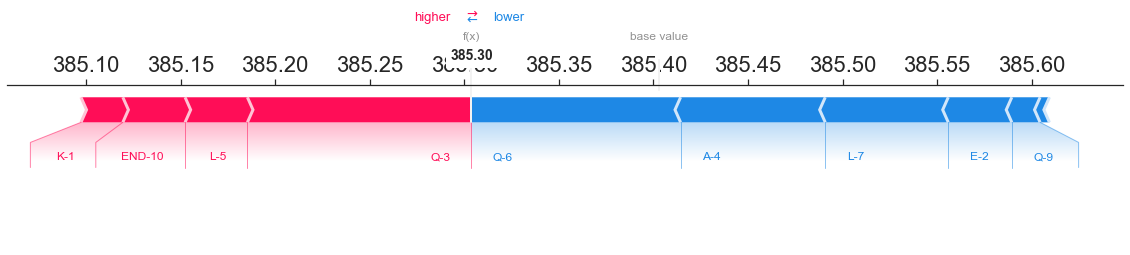

<Figure size 1080x576 with 0 Axes>

In [210]:
#Set to index of desired peptide
peptide_index = 2

shap.force_plot(explainer.expected_value, shap_values[output_index][peptide_index],show=False, features=x_test_decode[peptide_index],  matplotlib=True)
if savefig == True:
    plt.savefig(output_prefix+"-forceplot-"+ str(peptide_index)+filetype)
if showfig == True:
    plt.show()
plt.clf()

## SHAP values by position
Creates violin plots representing the SHAP values at each position. Can be useful in determining if a particular position in the
sequence contributes more substantially to final SHAP predictions

In [ ]:
#shap values by position

positionalshap = []
for value in shap_values[output_index][0]:
    positionalshap.append([])
i = 0
sns.set_style("white")
while i < len(shap_values[output_index]):
    j = 0
    while j < len(shap_values[output_index][i]):
        positionalshap[j].append(shap_values[output_index][i][j])
        j+=1
    i+=1
    
sns.violinplot(data=positionalshap)
fig = plt.gcf()
fig.set_size_inches(17.5,10)
plt.xlabel("Position")
plt.ylabel("SHAP Value")
plt.title("SHAP Values by Position")
sns.set(font_scale = 4.5)

i = 0
x = []
xt = []
while i < len(shap_values[output_index][0]):
    x.append(i)
    xt.append(str(i+1))
    i+=1

plt.xticks(x,xt)
if savefig == True:
    plt.savefig(output_prefix+"-positionSHAPrange"+filetype)
if showfig == True:
    plt.show()
plt.clf()

## SHAP values by Amino Acid
Creates violin plots representing the SHAP values of each input (amino acid) ignoring position. Can be useful in determining
if a particular input in the sequence contributes more substantially to final SHAP predictions

In [ ]:
#shap values by amino acid

aminoacidshaps = []
for value in list(input_dict.keys()):
    aminoacidshaps.append([])

i=0
while i < len(shap_values[output_index]):
    j = 0
    while j < len(shap_values[output_index][i]):
        aminoacidshaps[int(x_test[i][j])].append(shap_values[output_index][i][j])
        j+=1
    i+=1

sns.set_style("white")
sns.violinplot(data=aminoacidshaps)

i = 0
x = []
xt = list(input_dict.keys())
while i < len(list(input_dict.keys())):
    x.append(i)
    i+=1



plt.xticks(x,xt)
plt.xlabel("Amino Acid")
plt.ylabel("SHAP Value")
plt.title("SHAP Values by Input")
sns.set(font_scale = 4.5)

fig = plt.gcf()
fig.set_size_inches(17.5,10)
if savefig == True:
    plt.savefig(output_prefix + "_inputSHAPrange"+filetype)
if showfig == True:
    plt.show()
plt.clf()

## Mean SHAP value heatmap
Creates a heatmap of the mean SHAP values for each input at each position. Useful for determining if certain inputs at certain positions
have different impacts on model prediction

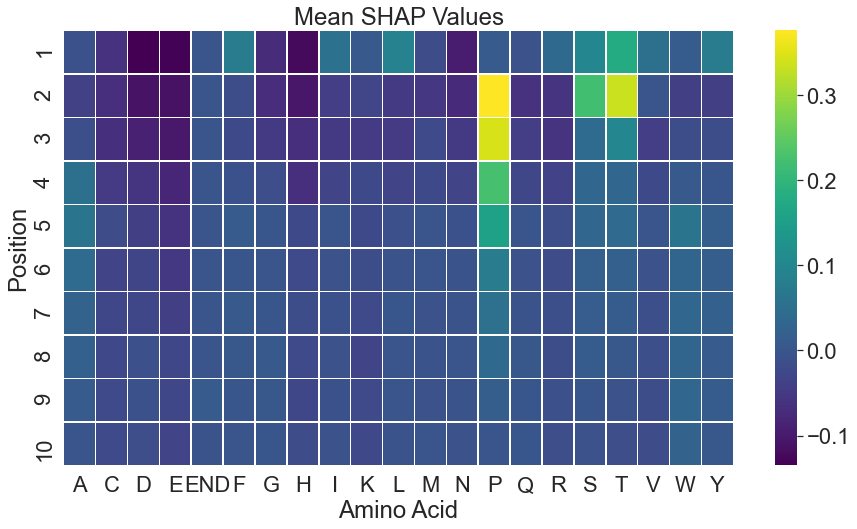

<Figure size 1080x576 with 0 Axes>

In [176]:
#Create Mean Heatmaps for CCS


y_axis_labels = []   
x = 0
    
    
char_index = list(input_dict.keys())



aa = []
ph = []
for value in char_index:
    ph.append([0.0])

i = 0
while i < len(shap_values[output_index][0]):
    aa.append(copy.deepcopy(ph))
    y_axis_labels.append(str(i+1))
    i+=1


#create 3D array to keep track of amino acid position shap values
#Change shap values index for each allele 0 = A001 1 = A002 2 = A008 3 = B008 4 = B017
i = 0

while i < len(x_test):
    j=0

    while j < len(x_test[i]):
        aa[j][char_index.index(rev_input_dict[x_test[i][j]])].append(shap_values[output_index][i][j])
       

        j+=1
    i+=1 

heatmap = []
i = 0
while i < len(aa):
    j=0
    heatmap.append([])
    while j < len(aa[i]):
        if len(aa[i][j]) > 1:


            #remove extra zeros
            if len(aa[i][j]) > 1:
                aa[i][j] = aa[i][j][1:]
            #mean
            heatmap[i].append((sum(aa[i][j])/float(len(aa[i][j]))))

        else:
            heatmap[i].append(0)

            #print(char_index[j] + str(i+1) + ": ")
            #print ("0")
        j+=1
    i+=1

if useweight == True:
    heatmap = np.array(heatmap)/weight
else:
    heatmap = np.array(heatmap)#*weight
if standardize == True:
    heatmap = heatmap/heatmap.max()

plt.figure()
x_axis_labels = char_index # labels for x-axis

sns.set(font_scale=2)

# figure size in inches
rcParams['figure.figsize'] = 15,8

ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, 
                 #vmax = 0.45,
                 #vmin = -0.45,
                 yticklabels=y_axis_labels,linewidths=.5,  cmap="viridis")


ax.set(xlabel='Amino Acid', ylabel='Position', title='Mean SHAP Values')
if savefig == True:
    ax.figure.savefig(output_prefix+'_heatmap'+filetype)

if showfig == True:
    plt.show()
plt.clf()
x+=1

## Dependence Plot
Creates dependence plots illustrating the dependencies between SHAP values and the input at another position. Creates plots for every
position. The compared position is defined by the "compareto" and "compared" variables. "compareto" can be "static", "preceding",
or "following", defining whether to illustrate the dependencies of a static position defined by the "compared" variable, the preceding position, or the following position.


In [ ]:
# create colormap depending on number of inputs
if (len(input_dict)<21):
    cmap1 = mpl.cm.tab20(np.arange(len(input_dict)-1))
elif (len(input_dict) == 21):
    upper = mpl.cm.tab20(np.arange(len(input_dict)-1))
    lower = [0,0,0,1]
    cmap1 = np.vstack(( lower, upper))
elif((len(input_dict)<41)):
    upper = mpl.cm.tab20b(np.arange(20))
    lower = mpl.cm.tab20c(np.arange(len(input_dict)-21))
    cmap1 = np.vstack(( lower, upper))
# convert to matplotlib colormap
cmap1 = mpl.colors.ListedColormap(cmap1, name='myColorMap', N=cmap1.shape[0])


#Create Dependance plots for each of the positions shap.dependence_plot(a, shap_valuestmp[b], x_testadj, feature_names=['pos1', 'pos2', 'pos3','pos4', 'pos5', 'pos6','pos7', 'pos8', 'pos9','pos10'],  cmap=cmap1,show = False, x_jitter=.1,  interaction_index=c)
# a = position looking at
# b = output_index looking at 
# c = position looking at interaction of i.e. colorbar

#Modify shap_values and data arrays to fix dependence_plot rounding on colorbar
shap_valuestmp = []

i = 0
while i<len(shap_values):
    j=0
    tmppeps = []
    while j < len (shap_values[i]):
        k=0
        tmpposs = []
        while k < len (shap_values[i][j]):
            tmpposs.append(shap_values[i][j][k])
            k+=1
        tmppeps.append(tmpposs)
        j+=1
    f=0
    #add 20% blank shap values to make color bar right
    blank = []
    while f < len(shap_values[0][0]):
        blank.append(0)
        f+=1
    f=0
    even = math.ceil((len(shap_values[0])*0.2)/2.)*2
    while f<even:
        tmppeps.append(blank)
        f+=1

    shap_valuestmp.append(tmppeps)
    
    i+=1
    
shap_valuestmp = np.array(shap_valuestmp)
i = 0
x_testadj = []

while i < len(x_test):
    tmp = []
    for value in x_test[i]:
        tmp.append(value)
    x_testadj.append(tmp)
    i+=1
    
f = 0

blank = []
while f < len(shap_values[0][0]):
    blank.append(-0.5)
    f+=1

i = 0
while i<(even/2):    
    x_testadj.append(copy.deepcopy(blank))
    i+=1
    
f = 0

blank = []
while f < len(shap_values[0][0]):
    blank.append(len(input_dict)-0.5)
    f+=1    

i = 0
while i<(even/2):
    x_testadj.append(copy.deepcopy(blank))
    
    i+=1
x_testadj = np.array(x_testadj)

i = 0
x = []
while i<len(list(input_dict.keys())):
    x.append(i)
    i+=1

xt = list(input_dict.keys())

feature_names = []
i = 0
while i < len(shap_values[0][0]):
    feature_names.append("pos" + str(i+1))
    i+=1


pos = 0

while pos < len(shap_values[0][0]):
    
    if compareto == 'preceding':
        if pos == 0:
            compared = len(shap_values[0][0])-1
        else:
            compared = pos-1
            
    if compareto == 'following':
        if pos == len(shap_values[0][0])-1:
            compared = 0
        else:
            compared = pos+1
    if pos != compared:
        

            
    
        shap.dependence_plot(pos, shap_valuestmp[output_index], x_testadj, 
                             feature_names=feature_names,  
                             cmap=cmap1, show = False, x_jitter=.1,  interaction_index=compared)
    
        plt.xticks(x,xt)

        fig = plt.gcf()
        fig.set_size_inches(10,10)

        cbs = []

        for ax in fig.axes:
            cbs.extend(ax.findobj(lambda obj: hasattr(obj, "colorbar") and obj.colorbar))

        colorb = cbs[0].colorbar
        
        z = [-0.5]
        for value in x:
            z.append(value)
        z.append(len(x)-0.5)

        zt = ['']
        for value in xt:
            zt.append(value)
        zt.append('')

        colorb.set_ticks(z)
        colorb.set_ticklabels(zt)

        colorb.set_ticks(z)
        colorb.set_ticklabels(zt)

        if savefig == True:
            plt.savefig(output_prefix+ "_dependence_pos" + str(pos) + filetype, bbox_inches="tight", format = 'svg', dpi=1000)
        if showfig == True:
            plt.show()
        plt.clf()
    pos+=1



## Dependence Analysis
Performs a dependence analysis on the SHAP values. This iterates through each input at each position and compares the mean of the
SHAP values given another input at another position to the remaining SHAP values by again iterating through each input at each position.
Removes all interactions with placeholder input elements. If you want to include these, set placeholder_index = -1.

Long calculation, ~20 minutes for demo data. 

Outputs a .csv with all significant interactions, calculated by Bonferroni corrected Mann-Whitney.

In [90]:
output_index = 0

In [91]:
#dependence analysis without ends

aa = []

i = 0
j = 0
blank = []
for value in list(input_dict.keys()):
    blank.append([0.0])
while i < len(shap_values[output_index][0]):
    aa.append(copy.deepcopy(blank))
    i+=1

i=0
j=0
k=0


#through the positions
while (i < len(shap_values[output_index][0])):
    j=0
    shappostmp = []
    #through the values
    while (j < 21):
        #through the list
        k = 0
        while (k < len(shap_values[output_index])):
            #place each shap value corresponding to an amino acid into a new array
            if j == x_test[k][i]:
                aa[i][j].append(shap_values[output_index][k][i])
                
            k+=1
        j+=1
    i+=1
    
aadep = []

i = 0

while i < len(shap_values[output_index][0]):
    aadep.append(copy.deepcopy(blank))
    i+=1

i = 0

temp = []
while i < len(shap_values[0][0]):
    temp.append(copy.deepcopy(aadep))
    i+=1

i = 0

deparray = []

while i < 21:
    deparray.append(copy.deepcopy(temp))
    i+=1
    
    
    
compaadep = []

i = 0

while i < len(shap_values[output_index][0]):
    compaadep.append(copy.deepcopy(blank))
    i+=1

i = 0

comptemp = []
while i < len(shap_values[output_index][0]):
    comptemp.append(copy.deepcopy(compaadep))
    i+=1
i = 0
compdeparray = []

while i < len(list(input_dict.keys())):
    compdeparray.append(copy.deepcopy(comptemp))
    i+=1
    
i=0
j=0
k=0
a = 0
b = 0
#through the amino acids
while (a<len(list(input_dict.keys()))):
    b=0
    if (a != placeholder_index):
        while (b < len(shap_values[output_index][0])):
            
            #through the positions
            i=0
            while (i < len(shap_values[output_index][0])):
                j=0

                #through the values
                if (b != i):
                    
                    while (j < len(list(input_dict.keys()))):
                        if (j!= placeholder_index):
                            
                            #through the list
                            k = 0
                            while (k < len(shap_values[output_index])):
                                
                                #place each shap value corresponding to an amino acid into a new array
                                if j == x_test[k][i] and x_test[k][b] == a:
                                    deparray[a][b][i][j].append(shap_values[output_index][k][i])
                                if j == x_test[k][i] and x_test[k][b] != a:
                                    compdeparray[a][b][i][j].append(shap_values[output_index][k][i])

                                k+=1
                        j+=1
                i+=1
            b+=1
    a+=1

    i = 0
j = 0
#Remove extra zeros
i=0
j=0
k=0
a = 0
b = 0
while (a<len(deparray)):
    b=0
    while (b < len (deparray[a])):
        i=0
        while(i < len(deparray[a][b])):
            j=0
            while(j < len(deparray[a][b][i])):
                
                if len(deparray[a][b][i][j])>1:
                    
                    deparray[a][b][i][j] = deparray[a][b][i][j][1:]
                
                if len(compdeparray[a][b][i][j])>1:
                    
                    compdeparray[a][b][i][j] = compdeparray[a][b][i][j][1:]
                
                    
                j+=1
            i+=1
        b+=1
    a+=1
    
outputarray = []

a = 0
b = 0
c = 0
d = 0
e = 0

while a < len(deparray):
    b = 0
    while b < len(deparray[a]):
        c = 0
        while c<len(deparray[a][b]):
            d = 0
            while d < len(deparray[a][b][c]):
                try:
                    stat,test = st.mannwhitneyu(deparray[a][b][c][d][1:], compdeparray[a][b][c][d][1:])
                except ValueError:
                    stat = 1
                    test = 1
                if test<1 and test>0:
                    
                    outputarray.append([test, list(input_dict.keys())[a],b+1,c+1, list(input_dict.keys())[d],len(deparray[a][b][c][d][1:]),len(compdeparray[a][b][c][d][1:]),np.mean(deparray[a][b][c][d][1:]),np.mean(compdeparray[a][b][c][d][1:]), abs(np.mean(compdeparray[a][b][c][d][1:])-np.mean(deparray[a][b][c][d][1:])), np.mean(deparray[a][b][c][d][1:])-np.mean(compdeparray[a][b][c][d][1:])])
                    e+=1
                d+=1
            c+=1
        b+=1
    a+=1

outputdf = pd.DataFrame(outputarray, columns = ["mw pvalue", "compared amino acid", "compared position", "position", "amino acid","compared size","total size", "compared mean", "total mean", "abs difference", "difference"]) 
corrmwtest = multitest.multipletests(outputdf['mw pvalue'].tolist(), alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)
outputdf.insert(1, "corr mw pvalue", corrmwtest[1])

outputdf = outputdf.sort_values(by='corr mw pvalue', ascending=True)
posdiff = abs(outputdf['position']-outputdf['compared position'])
outputdf['distance']=posdiff
outputdf = outputdf.loc[outputdf['corr mw pvalue'] <= 0.05]
#save dependence analysis
outputdf.to_csv(output_prefix +'_dependenceanalysis.csv',index=False)

divide by zero encountered in double_scalars


## Load Dependence Analysis
Load the dependence analysis from .csv at defined path.

In [ ]:
#load dependence analysis

outputdf = pd.read_csv(output_prefix +'_dependenceanalysis.csv')

## Distance/Absolute Difference Significant Interactions Plot
Creates a plot with all significant dependencies organized by the distance between the interacting inputs. Plots the absolute difference 
between the mean of the dependent interactions and the remaining SHAP values. Requires the dependence analysis to be calculated or loaded.

In [ ]:
sns.set_style("white") 
sns.set(style="white", color_codes=True, font_scale=4.5)
a = sns.boxplot(x='distance', y= 'abs difference', data=outputdf)
a = sns.stripplot(x='distance', y= 'abs difference', data=outputdf,color=".25")

fig = plt.gcf()
fig.set_size_inches(20,15)
#plt.yticks([0,2,4,6,8, 10] , ["0",'2','4','6','8',''])

if savefig == True:
    plt.savefig(output_prefix+"_depanalysis_distance_absdifference"+filetype)

if showfig == True:
    plt.show()
plt.clf()

## Interaction Type Analysis
Adds additional categories to the dependence analysis dataframe. Requires the `input_dict` dictionary to link the inputs to the 
canonical 20 amino acid single letter codes and for the placeholder to be linked to "END". Requires the dependence analysis to be calculated or loaded.

Categorizes distance to End, Neighbor, Near, and Far for interactions involving END, distance = 1, distance from 2 to 6, and 
distance greater than 6 respectively.

Categorizes amino acids by type and size, 
and categorizes the interactions between the categories. Amino acids are categorized by chemistry into positive, negative,
polar, hydrophobic, or END for placeholders. Amino acids are categorized by size into very large, large, medium, small, very small,
or END for placeholders. Interactions are categorized by charge attraction, charge repulsion, polar, end for placeholders,  
hydrophobic if comments are removed, and other. These are futher categorized into generally attractive, repulsive, and End.

In [ ]:

#outputdf['distance_end']=['-1' if x=="End" else outputdf['distance_end'] for x in outputdf['compared amino acid']]
outputdf['Close'] = ["End" if x <= -1 
                     else 'Neighbor' if x==1 
                     else 'Near' if 2<=x<7 
                     else 'Far' for x in outputdf['distance']]

outputdf['amino acid category'] = ['Positive' if (x== "R" or x == "H" or x == "K")  
                                   else 'Negative' if (x== "D" or x == "E") 
                                   else 'Polar' if (x== "S" or x == "T" or x == "N" or x == "Q" or x == "Y") 
                                   else 'End' if (x=='END')  
                                   else 'Hydrophobic' for x in outputdf['amino acid']]

outputdf['compared amino acid category'] = ['Positive' if (x== "R" or x == "H" or x == "K")  
                                            else 'Negative' if (x== "D" or x == "E") 
                                            else 'Polar' if (x== "S" or x == "T" or x == "N" or x == "Q" or x == "Y")  
                                            else 'End' if (x=='END')  
                                            else 'Hydrophobic' for x in outputdf['compared amino acid']]


outputdf['amino acid size'] = ['Very Large' if (x== "F" or x == "W" or x == "Y")  
                               else 'Large' if (x== "I" or x == "L" or x=="M" or x == "K" or x =="R") 
                               else 'Medium' if (x== "V" or x == "H" or x == "E" or x == "Q") 
                               else 'Small' if (x=='C' or x=='P' or x=='T' or x == 'D' or x == 'N') 
                               else 'End' if (x=="END")  else 'Very Small' for x in outputdf['amino acid']]

outputdf['compared amino acid size'] = ['Very Large' if (x== "F" or x == "W" or x == "Y")  
                                        else 'Large' if (x== "I" or x == "L" or x=="M"or x == "K" or x =="R") 
                                        else 'Medium' if (x== "V" or x == "H" or x == "E" or x == "Q") 
                                        else 'Small' if (x=='C' or x=='P' or x=='T'or x == 'D' or x == 'N') 
                                        else 'End' if (x=="END")  else 'Very Small' for x in outputdf['compared amino acid']]


interactiontype = []
interactiontypecategory = []

i = 0
while i < len(outputdf['amino acid category'].tolist()):
    if outputdf['amino acid category'].tolist()[i] == 'Positive':
        if outputdf['compared amino acid category'].tolist()[i] == 'Positive':
            interactiontype.append('Charge Repulsion')
            interactiontypecategory.append("Repulsive")
        elif outputdf['compared amino acid category'].tolist()[i] == 'Negative':
            interactiontype.append('Charge Attraction')
            interactiontypecategory.append("Attraction")
        elif outputdf['compared amino acid category'].tolist()[i] == 'Polar':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif outputdf['compared amino acid category'].tolist()[i] == 'End':
            interactiontype.append('zEnd')
            interactiontypecategory.append("zEnd")
        else:
            interactiontype.append('Other')
            interactiontypecategory.append("Repulsive")
    elif outputdf['amino acid category'].tolist()[i] == 'Negative':
        if outputdf['compared amino acid category'].tolist()[i] == 'Positive':
            interactiontype.append('Charge Attraction')
            interactiontypecategory.append("Attraction")
        elif outputdf['compared amino acid category'].tolist()[i] == 'Negative':
            interactiontype.append('Charge Repulsion')
            interactiontypecategory.append("Repulsive")
        elif outputdf['compared amino acid category'].tolist()[i] == 'Polar':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif outputdf['compared amino acid category'].tolist()[i] == 'End':
            interactiontype.append('zEnd')
            interactiontypecategory.append("zEnd")
        else:
            interactiontype.append('Other')
            interactiontypecategory.append("Repulsive")
    elif outputdf['amino acid category'].tolist()[i] == 'Polar':
        if outputdf['compared amino acid category'].tolist()[i] == 'Positive':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif outputdf['compared amino acid category'].tolist()[i] == 'Negative':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif outputdf['compared amino acid category'].tolist()[i] == 'Polar':
            interactiontype.append('Polar')
            interactiontypecategory.append("Attraction")
        elif outputdf['compared amino acid category'].tolist()[i] == 'End':
            interactiontype.append('zEnd')
            interactiontypecategory.append("zEnd")
        else:
            interactiontype.append('Other')
            interactiontypecategory.append("Repulsive")
    #elif outputdf['amino acid category'].tolist()[i] == 'Hydrophobic':
    #    if outputdf['compared amino acid category'].tolist()[i] == 'Hydrophobic':
    #        interactiontype.append('Hydrophobic')
    #        interactiontypecategory.append("Attraction")
    #    elif outputdf['compared amino acid category'].tolist()[i] == 'End':
    #        interactiontype.append('zEnd')
    #        interactiontypecategory.append("zEnd")
    #    else:
    #        interactiontype.append('Other')
    #        interactiontypecategory.append("Repulsive")
            
    elif outputdf['amino acid category'].tolist()[i] == 'End':
        interactiontype.append('zEnd')
        interactiontypecategory.append("zEnd")
    else:
        interactiontype.append('Other')
        interactiontypecategory.append("Repulsive")
    i+=1
            
print(len(outputdf['compared amino acid category'].tolist()))          
print(len(outputdf['amino acid category'].tolist()))      
print(len(interactiontype))


outputdf['interaction type'] = interactiontype
outputdf['interaction type category'] = interactiontypecategory
outputdf['combined'] = outputdf['interaction type'] +"-"+outputdf['Close']

sizetype = []
i = 0
while i < len(outputdf['amino acid size'].tolist()):
    if outputdf['amino acid size'].tolist()[i] == 'Very Large':
        if outputdf['compared amino acid size'].tolist()[i] == 'Very Large':
            sizetype.append('Very Large - Very Large')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Large':
            sizetype.append('Very Large - Large')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Medium':
            sizetype.append('Very Large - Medium')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Small':
            sizetype.append('Very Large - Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Very Small':
            sizetype.append('Very Large - Very Small')
            
        else:
            sizetype.append('zEnd')
            
    elif outputdf['amino acid size'].tolist()[i] == 'Large':
        if outputdf['compared amino acid size'].tolist()[i] == 'Very Large':
            sizetype.append('Very Large - Large')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Large':
            sizetype.append('Large - Large')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Medium':
            sizetype.append('Large - Medium')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Small':
            sizetype.append('Large - Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Very Small':
            sizetype.append('Large - Very Small')
            
        else:
            sizetype.append('zEnd')  
            
    elif outputdf['amino acid size'].tolist()[i] == 'Medium':
        if outputdf['compared amino acid size'].tolist()[i] == 'Very Large':
            sizetype.append('Very Large - Medium')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Large':
            sizetype.append('Large - Medium')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Medium':
            sizetype.append('Medium - Medium')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Small':
            sizetype.append('Medium - Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Very Small':
            sizetype.append('Medium - Very Small')
            
        else:
            sizetype.append('zEnd') 
            
    elif outputdf['amino acid size'].tolist()[i] == 'Small':
        if outputdf['compared amino acid size'].tolist()[i] == 'Very Large':
            sizetype.append('Very Large - Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Large':
            sizetype.append('Large - Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Medium':
            sizetype.append('Medium - Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Small':
            sizetype.append('Small - Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Very Small':
            sizetype.append('Small - Very Small')
            
        else:
            sizetype.append('zEnd') 

    elif outputdf['amino acid size'].tolist()[i] == 'Very Small':
        if outputdf['compared amino acid size'].tolist()[i] == 'Very Large':
            sizetype.append('Very Large - Very Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Large':
            sizetype.append('Large - Very Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Medium':
            sizetype.append('Medium - Very Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Small':
            sizetype.append('Small - Very Small')
            
        elif outputdf['compared amino acid size'].tolist()[i] == 'Very Small':
            sizetype.append('Very Small - Very Small')
            
        else:
            sizetype.append('zEnd')
    
            
            
    elif outputdf['amino acid size'].tolist()[i] == 'End':
        sizetype.append('zEnd')
        
    else:
        sizetype.append('Other')
        
    i+=1
            
outputdf['size type'] = sizetype
outputdf['size combined'] = outputdf['interaction type'] +"-"+outputdf['size type']
outputdf['size distance'] = outputdf['Close'] +"-"+outputdf['size type']

#outputdf

## Interaction Type Significant Interactions Plot
Creates a plot with all significant dependencies organized by the interaction type between the interacting inputs. Plots the difference 
between the mean of the dependent interactions and the remaining SHAP values. Requires the dependence analysis to be calculated or loaded 
and for the interaction type analysis to have been run.

In [ ]:
outputdf = outputdf.sort_values(by='interaction type')
sns.set(style="white", color_codes=True, font_scale=4.5)
a=sns.violinplot(x='interaction type', y= 'difference', data=outputdf, width=1, bw=.3, scale_hue=True)
#a=sns.boxplot(x='combined', y= 'difference', data=outputdf)
a = sns.stripplot(x='interaction type', y= 'difference', data=outputdf,color=".25")
#a.set_yscale("log")
fig = plt.gcf()
fig.set_size_inches(20,15)

#plt.plot([0, 1], [0, 0], linewidth=2)
#plt.plot([0, 0], [15, 15], linewidth=0)
a.tick_params(axis='x', rotation=90)

if savefig == True:
    plt.savefig(prefix + "interactiontype" + filetype)
if showfig == True:
    plt.show()
plt.clf()

## Interaction Type and Distance Significant Interactions Plot
Creates a plot with all significant dependencies organized by the interaction type combined with the distance between the interacting inputs. Plots the difference 
between the mean of the dependent interactions and the remaining SHAP values. Requires the dependence analysis to be calculated or loaded 
and for the interaction type analysis to have been run.

In [ ]:

outputdf = outputdf.sort_values(by='combined')
sns.set(style="white", color_codes=True, font_scale=4.5)

a=sns.boxplot(x='combined', y= 'difference', data=outputdf)
a = sns.stripplot(x='combined', y= 'difference', data=outputdf,color=".25")
#a.set_yscale("log")
fig = plt.gcf()
fig.set_size_inches(20,15)

#plt.plot([0, 1], [0, 0], linewidth=2)
#plt.plot([0, 0], [15, 15], linewidth=0)
a.tick_params(axis='x', rotation=90)

if savefig == True:
    plt.savefig(prefix + "interactiontype-distance" + filetype)
if showfig == True:
    plt.show()
plt.clf()